In [1]:
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import datetime as dt
import numpy as np

from utils import explain

today = dt.datetime.strftime(dt.datetime.today().date(), '%b %d, %Y')


 ----- HELPER MODULE IMPORTED ------

    For information on the helper module:
        run 'help(explain)' in any cell. 
        
    To directly use:
        run 'explain.what_is()' with no parameters.
    


#### Create Dataframes

In [2]:
files = sorted(['data/' + _ for _ in os.listdir('data/') if '.txt' not in _])

In [3]:
bus_char_df = pd.read_csv(files[0])
bus_own_df = pd.read_csv(files[1])
bus_tech_df = pd.read_csv(files[2])
comp_sum_df = pd.read_csv(files[3])
slbo = pd.read_csv(files[4])

state_code_path = 'https://raw.githubusercontent.com/jedc4xer/abs_group_assessment/main/data/state_codes.csv'
state_codes = pd.read_csv(state_code_path)


In [205]:
bus_char_df.head()

,name,buschar_label,emp,firmpdemp,geo_id,industry_code,industry,payann,qdesc_label,race_group_label,rcppdemp,gender,yibszfi_label,state
0,Mississippi,All firms,920447,40856,0400000US28,0,Total for all sectors,34137231,OWNRNUM,Total,0,Total,All firms,28]
1,Mississippi,1 person,80964,10704,0400000US28,0,Total for all sectors,2835519,OWNRNUM,Total,0,Total,All firms,28]
2,Mississippi,2 to 4 people,59086,5956,0400000US28,0,Total for all sectors,2031186,OWNRNUM,Total,0,Total,All firms,28]
3,Mississippi,5 to 10 people,13497,360,0400000US28,0,Total for all sectors,618245,OWNRNUM,Total,0,Total,All firms,28]
4,Mississippi,11 or more people,106361,604,0400000US28,0,Total for all sectors,4807141,OWNRNUM,Total,0,Total,All firms,28]


In [8]:
def clean_for_map(df, target = 'industry'):
    if target not in ['gender','race_group_label','industry']:
        possible = ", ".join(['gender','race_group_label','industry'])
        print(f'You must choose one of: {possible}')
        return
    label = {'gender': 'Owner Gender','race_group_label': 'Owner Race','industry':'Industry'}[target]
    
    subset = df[(df.payann != 0) & (df.gender != 'Total') & (df.race_group_label != 'Total') & (df.industry_code != '00')]
    subset = subset[['name','geo_id',target,'payann','firmpdemp','emp']]
    subset['payann'] = subset['payann'] * 1000
    subset['avg_pay'] = subset.apply(lambda row: row.payann/row.emp, axis = 1)

    subset_agg = subset.groupby(
        by = ['name']
            )[['avg_pay']].agg(max_pay = ('avg_pay','max'))

    subset_agg.reset_index(inplace = True)

    grouped = pd.merge(subset, subset_agg, left_on = 'name', right_on = 'name', how = 'left')
    
    grouped = grouped[(grouped.avg_pay == grouped.max_pay)].reset_index(drop = True)
    grouped = grouped.sort_values(by = 'name').reset_index(drop = True)
    grouped = grouped.drop_duplicates().reset_index(drop = True)

    grouped = pd.merge(grouped,state_codes, left_on = 'name', right_on = 'State', how = 'left')

    grouped = grouped[['name',target,'avg_pay','Postal Abbr.']]

    diffs = set(subset_agg.name.tolist()) - set(grouped.name.tolist())
    if len(diffs) > 0:
        print('There are some states missing.')
    return grouped, target, label

def plot_maps(grouped, target):
    grouped, target, label = clean_for_map(grouped, target)
    
    if target == 'gender':
        color_scheme = px.colors.qualitative.Plotly[2:]
    else:
        color_scheme = px.colors.qualitative.Bold
        
    customdata = np.stack((grouped['name'],grouped[target]),axis = -1)
    
    mapfig = px.choropleth(grouped, 
                           title = f'Highest Average Pay based on {label}',
                           locations = 'Postal Abbr.',
                           locationmode = "USA-states",
                           scope = 'usa',
                           color = target,
                           hover_data = ['name',target,'avg_pay'],
                           color_discrete_sequence = color_scheme,
                           height = 600,
                           width = 1300,
                           )

    mapfig.add_annotation(
        text = (f"Created by: Jed Dryer<br>{today}<br>Source: US Census - 2019 ABS"),
        showarrow=False,
        x = .54,
        y = .01,
        xref='paper',
        yref='paper' ,
        xanchor='left',
        yanchor='bottom',
        xshift=-1,
        yshift=-3,
        font=dict(size=10, color="grey"),
        align="right",
        )

    mapfig.update_layout(margin={"r":3,"t":30,"l":0,"b":10}, dragmode = False)
    mapfig.update_layout(title_y = 0.95, title_x = 0.25, title_font_size = 18,
                        legend = dict(x=0.9,y=0.6))
    mapfig.update_traces(hovertemplate = '<b>State: %{customdata[0]}</b><br>Value: %{customdata[1]}')
    mapfig.update_geos(resolution=50,showlakes=True, lakecolor="Lightblue", subunitcolor = 'black')
    #save_label = "".join(_.lower() for _ in label if _.isalpha())
    #mapfig.write_html(f'highest_avg_pay_{save_label}.html')
    #mapfig.show()
    return mapfig

reasons = ['gender','race_group_label','industry']
maps = []
for reason in reasons:
    maps.append(plot_maps(comp_sum_df, reason))
    
with open('company_pay_maps.html', 'w') as mapfile:
    for fig in maps:
        mapfile.write(fig.to_html(full_html = False, include_plotlyjs='cdn'))
    mapfile.close()


In [556]:
reason_owned = bus_own_df[
    (bus_own_df['qdesc_label'] == 'REASONOWN') &
    (~bus_own_df['industry'].str.contains('Total')) &
    (~bus_own_df['gender'].str.contains('All')) &
    (bus_own_df['ownchar_label'].str.contains(':'))]

reason_owned[['reason','importance']] = reason_owned.apply(
    lambda row: row['ownchar_label'].split(":"), axis = 1, result_type = 'expand'
)

reason_owned = reason_owned[['industry','gender','reason','importance','ownpdemp']]

grouped_reason = reason_owned.groupby(
    by = ['industry','reason','importance'])[['ownpdemp']].agg(
    responses = ('ownpdemp', 'sum')
)

grouped_reason['ratio'] = 100 * (grouped_reason['responses'] / grouped_reason.groupby(level = [0,1])['responses'].transform('sum'))
grouped_reason['ratio'] = grouped_reason['ratio'].round(2)
grouped_reason.reset_index(inplace = True)

accom_subset = grouped_reason[(grouped_reason['industry'].str.contains('inanc|ducati'))]
accom_subset.sort_values(by = ['importance','ratio'], ascending = False, inplace = True)
accom_subset.rename(columns = {'ratio': 'Percent of Total'}, inplace = True)
picked_industry = accom_subset['industry'].unique().tolist()

C:\Users\Work\anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [557]:
reasons = grouped_reason.reason.unique().tolist()
longest_reason = max(reasons, key = len)
longest_reason = "<" + longest_reason + ">"
longest_reason = len(longest_reason)
new_reasons = {}
for reason in reasons:
    old_reason = reason
    if len(reason) != longest_reason:
        reason = " " + reason + " "
        cntr = 0
    while len(reason) < longest_reason:
        if cntr % 3 == 0:
            reason = "-" + reason + "-"
        else:
            reason = " " + reason + " "
        cntr += 1
    
    if len(reason) < 30:
        reason = reason + "-"
    reason = "<" + reason + ">"
    
    new_reasons[old_reason] = reason
    
for key in new_reasons.keys():
    print(new_reasons[key])
accom_subset['reason'] = accom_subset['reason'].apply(lambda x: new_reasons[x])

< - Balance work and family - ->
<  - Best avenue for ideas -  ->
< - Carry on family business - >
<-  - Couldn't find a job -  -->
<-  -  - Flexible hours -  -  ->
< Friend or family role model ->
<-  -  - Greater income -  -  ->
< -  - Help my community -  - ->
< -  -  -  - Other -  -  -  - ->
<  - Start my own business -  ->
< - Wanted to be my own boss - >
<-  -  - Work for self -  -  -->


C:\Users\Work\AppData\Local\Temp/ipykernel_23740/1238197172.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [592]:

fig = px.bar(accom_subset, x = 'Percent of Total', y = 'reason', color = 'importance',
            width = 1300, height = 600, orientation = 'h',
            hover_data = ['responses','Percent of Total'], text = 'Percent of Total', facet_col = 'industry',
            facet_col_spacing=0.18
        )
fig.update_layout(title = 'Reasons for Starting a Company')
fig.update_layout(yaxis_title = None)

fig.update_traces(textposition = 'inside', insidetextanchor = 'middle', textfont = {'color': 'white'})
fig.update_yaxes(side = 'right')
fig.update_xaxes(ticks = 'outside')
fig.update_layout(title_y = .98, title_x = 0.003, title_font_size = 22)
fig.update_layout(xaxis_title = "Percent of Total", uniformtext_minsize = 13,
                 uniformtext_mode = 'hide', paper_bgcolor = 'white', plot_bgcolor = 'white',
                 legend = dict(orientation = 'h', x=0,y=1.15, font = dict(size=13)))
fig.update_layout(margin={"r":0,"t":90,"l":0,"b": 90}, dragmode = False)

fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[1]))

fig.add_annotation(
        text = (f"Created by: Jed Dryer | {today} | Source: US Census - 2019 ABS"),
        showarrow=False,
        x = .70,
        y = -.19,
        xref='paper',
        yref='paper' ,
        xanchor='left',
        yanchor='bottom',
        xshift=-1,
        yshift=-3,
        font=dict(size=10, color="grey"),
        align="right",
        )

fig.write_html('stacked_reasons.html')

In [ ]:
grouped_reason['ratio'] = 100 * (grouped_reason['responses'] / grouped_reason.groupby(level = [0,1])['responses'].transform('sum'))
grouped_reason['ratio'] = grouped_reason['ratio'].round(2)
grouped_reason.reset_index(inplace = True)

In [ ]:
# This analysis is assuming that the same companies that are 

In [35]:
robotics['firmpdemp']

10       53464
14         443
836      11878
1656     81173
1660       490
         ...  
40476       35
41101    94489
41121      525
42371    13603
42375       22
Name: firmpdemp, Length: 101, dtype: int64

In [212]:
tech_subset = bus_tech_df[(bus_tech_df['industry_code'] == '00') & (bus_tech_df['gender'] == 'Total') & (bus_tech_df['emp'] != 0)].drop_duplicates()
tech_subset = tech_subset[['name','emp','firmpdemp','industry','payann','techuse_label']]
tech_subset = tech_subset[(tech_subset['techuse_label'].str.contains('Did not use|High use'))]
tech_subset[['tech','usage']] = tech_subset.apply(lambda row: row['techuse_label'].split(":"), axis = 1, result_type = 'expand')

tech_subset['total_companies'] = tech_subset.groupby(by = ['name','tech'])['firmpdemp'].transform('sum')
tech_subset['average_pay'] = 1000 * (tech_subset['payann'] / tech_subset['emp'])
tech_subset.sort_values(by = ['usage', 'firmpdemp'], ascending = False, inplace = True)
tech_subset.head(5)

,name,emp,firmpdemp,industry,payann,techuse_label,tech,usage,total_companies,average_pay
3380,California,2947626,102413,Total for all sectors,215223062,Specialized Software: High use,Specialized Software,High use,424022,73015.729268
3372,California,2216353,70133,Total for all sectors,185466118,Cloud-Based: High use,Cloud-Based,High use,420548,83680.766557
7205,Florida,1754627,66077,Total for all sectors,83596882,Specialized Software: High use,Specialized Software,High use,256408,47643.676975
35987,Texas,2338287,62392,Total for all sectors,140518775,Specialized Software: High use,Specialized Software,High use,234256,60094.750987
26225,New York,1243710,45815,Total for all sectors,86164683,Specialized Software: High use,Specialized Software,High use,233572,69280.365198


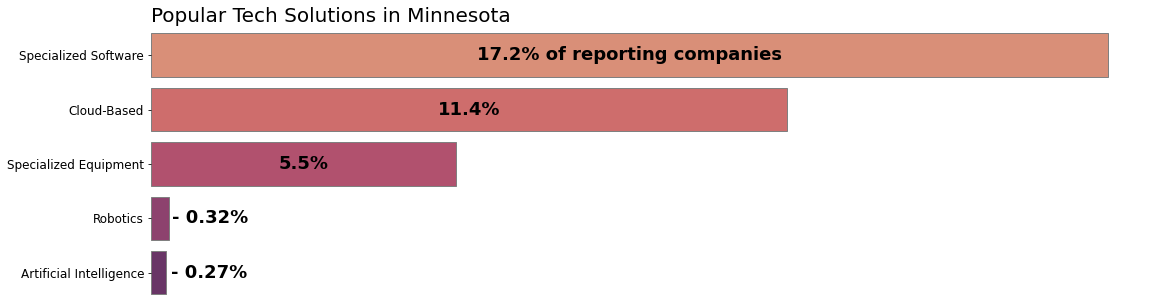

In [403]:
subset = bus_tech_df[(bus_tech_df['industry'] == 'Total for all sectors')][['name','firmpdemp','techuse_label']]
subset


subset[['tech','usage']] = subset.apply(lambda row: row['techuse_label'].split(":"), axis = 1, result_type = 'expand')
subset = subset[(subset['usage'].str.contains('Total R|High'))]
subset = subset[(subset['name']) == 'Minnesota'][['firmpdemp','tech','usage']]
subset['total_respondents'] = subset.groupby(by = ['tech'])['firmpdemp'].transform('max')
subset = subset[(subset['usage'].str.contains('High use'))]
subset['rate_of_high_use'] = 100 * (subset['firmpdemp'] / subset['total_respondents'])
subset.sort_values(by = 'rate_of_high_use', ascending = False, inplace = True)

fig = plt.figure(figsize = (18,5))

plt.title('Popular Tech Solutions in Minnesota', fontsize = 20, loc = 'left')
ax = sns.barplot(data = subset, x = 'rate_of_high_use', y = 'tech', palette = 'flare',
                edgecolor = 'grey')
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_yticklabels(ax.get_yticklabels(), size = 12)
ax.tick_params(bottom = False)
for c in ax.containers:
    labels = []
    for v in c:
        if (h := v.get_width()) > 14:
            lab = f'{(h/100)*100:0.1f}% of reporting companies'
        elif (h := v.get_width()) > .8:
            lab = f'{(h/100)*100:0.1f}%'
        else:
            lab = f'{" "*16}- {(h/100)*100:0.2f}%'
        labels.append(lab)
   
    ax.bar_label(c,labels=labels,label_type = 'center',fontsize = 18,color= 'black', weight = 'bold')
ax.set(xticklabels = [])

sns.despine(left = True, bottom = True)
fig.savefig('pop_tech.png')

In [ ]:
fig = plt.figure(figsize = (12,5))

plt.title('Popular Tech Solutions in Minnesota', fontsize = 20, loc = 'left')
ax = sns.barplot(data = subset, x = 'rate_of_high_use', y = 'tech', palette = 'flare')
ax.set_ylabel('')
ax.set_xlabel('Percentage of Responding Companies using Technology', fontsize = 14)
ax.set_yticklabels(ax.get_yticklabels(), size = 12)
ax.tick_params(bottom = False)
for c in ax.containers:
    labels = [
        f'{(h/100)*100:0.1f}%' if (
            h := v.get_width()) > .8 else 
        f'{" "*16}- {(h/100)*100:0.2f}%' for v in c
    ]
    
    ax.bar_label(c,labels=labels,label_type = 'center',fontsize = 18,color= 'black', weight = 'bold')
ax.set(xticklabels = [])

sns.despine(left = True, bottom = True)
    

In [296]:
subset = bus_tech_df[(bus_tech_df['industry'] == 'Total for all sectors')][['name','firmpdemp','techuse_label']]
subset


subset[['tech','usage']] = subset.apply(lambda row: row['techuse_label'].split(":"), axis = 1, result_type = 'expand')
subset = subset[(subset['usage'].str.contains('Total R|High'))]
subset = subset[['name','firmpdemp','tech','usage']]
subset['total_respondents'] = subset.groupby(by = ['tech'])['firmpdemp'].transform('max')
subset = subset[(subset['usage'].str.contains('High use'))]
subset['rate_of_high_use'] = 100 * (subset['firmpdemp'] / subset['total_respondents'])
subset

,firmpdemp,tech,usage,total_respondents,rate_of_high_use
6,10974,Specialized Software,High use,597544,1.836517
14,443,Robotics,High use,601361,0.073666
24,356,Artificial Intelligence,High use,597511,0.059580
32,5505,Cloud-Based,High use,601214,0.915647
116,3534,Specialized Equipment,High use,601391,0.587638
...,...,...,...,...,...
41991,0,Artificial Intelligence,High use,597511,0.000000
42032,885,Specialized Equipment,High use,601391,0.147159
42359,1152,Cloud-Based,High use,601214,0.191612
42367,1959,Specialized Software,High use,597544,0.327842
